# PointNet Sub Models Testing
## For Semantic Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

plotpath = '/home/russbate/MLPionCollaboration/LCStudies/segmentation/Plots/October/'

## Declare GPUs and Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

import tensorflow as tf
from tensorflow.python.client import device_lib

## TF and Keras

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
print(tf.__version__)

2.6.0


## Load Data
### X = [Energy, Eta, Phi, rPerp]
### Y = [EM Energy, non EM Energy]

In [4]:
t0 = cput()
Xraw = np.load('/data/atlas/rbate/PIPM_X_15_files.npy', mmap_mode='r')[:,:,:]
Yraw = np.load('/data/atlas/rbate/PIPM_Y_segm_15_files.npy', mmap_mode='r')[:,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/X_pipm_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 4))

Y = np.lib.format.open_memmap('/data/atlas/rbate/Y_pipm_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
np.copyto(dst=Y, src=Yraw[:,:,:], casting='same_kind', where=True)

t1 = cput()

Energy_EM = np.ndarray.copy(Yraw[:,:,0])
Energy_nonEM = np.ndarray.copy(Yraw[:,:,1])
nz_mask = (Energy_EM + Energy_nonEM) != 0

print(np.shape(nz_mask))
print(np.count_nonzero(nz_mask))

# Make sure that non-zero elements are copied as zeros due to mis-match
np.copyto(dst=X, src=Xraw[:,:,:4], casting='same_kind', where=True)
X[np.invert(nz_mask),:] = 0
t2 = cput()

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')
print('Time to copy elements: '+str(t2-t1)+' (s)')

(30283, 848, 5)
(30283, 848, 2)
(30283, 848)
3161465
Time to load memory mapped data: 1.166586373001337 (s)
Time to copy elements: 3.6751423301175237 (s)


### Point Normalization

In [5]:
t0 = cput()
target_ratio = np.zeros(nz_mask.shape)
target_ratio[nz_mask] = Energy_EM[nz_mask] / (Energy_EM[nz_mask] + Energy_nonEM[nz_mask])
Y = target_ratio

t1 = cput()

X[:,:,1:4] = dsu.to_xyz(np.ndarray.copy(Xraw[:,:,1:4]), nz_mask)

t2 = cput()

## ENERGY ##
log_E_mask = Xraw[:,:,0] > 0
X[log_E_mask,0] = np.log(np.ndarray.copy(Xraw[log_E_mask,0]))

## X ##
X[:,:,1] = np.ndarray.copy(Xraw[:,:,1])/3000

## Y ##
X[:,:,2] = np.ndarray.copy(Xraw[:,:,2])/1000

## Z ##
X[:,:,3] = np.ndarray.copy(Xraw[:,:,3])/1000
t3 = cput()

print('Time create target ratio: '+str(t1-t0)+' (s)')
print('Time to convert to xyz: '+str(t2-t1)+' (s)')
print('Time to normalize: '+str(t3-t1)+' (s)')
print('Total time: '+str(t2-t0)+' (s)')
print('Target shape: '+str(Y.shape))
print('Input shape: '+str(X.shape))

Time create target ratio: 0.2730841310694814 (s)
Time to convert to xyz: 2.378917381167412 (s)
Time to normalize: 3.997897418215871 (s)
Total time: 2.652001512236893 (s)
Target shape: (30283, 848)
Input shape: (30283, 848, 4)


## Build Model

In [6]:
def PointNetMinMinMin(shape, name):
    inputs = keras.Input(shape=(848, 4), name="input")

    mask = layers.Masking(mask_value=0.0, input_shape=(32, 4))(inputs)

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(mask)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)

    dense_1 = layers.Dense(200)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name="activation_1")(t_dist_1)

    dense_2 = layers.Dense(200)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name="activation_2")(t_dist_2)

    dense_3 = layers.Dense(100)
    t_dist_3 = layers.TimeDistributed(dense_3, name='t_dist_3')(activation_2)
    activation_3 = layers.Activation('relu', name="activation_3")(t_dist_3)

    dense_4 = layers.Dense(50)
    t_dist_4 = layers.TimeDistributed(dense_4, name='t_dist_4')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(t_dist_4)

    dense_5 = layers.Dense(1)
    t_dist_5 = layers.TimeDistributed(dense_5, name='t_dist_5')(activation_4)
    activation_5 = layers.Activation('sigmoid', name="activation_5")(t_dist_5)

    # outputs = layers.Dense(10)(x)

    return keras.Model(inputs, outputs=activation_5, name=name)

In [7]:
pnet_MinMinMin = PointNetMinMinMin(shape=(None, X.shape[1], X.shape[2]), name="PointNet---")

point_optimizer = keras.optimizers.Adam(learning_rate=0.001)

pnet_MinMinMin.compile(loss='mse', optimizer=point_optimizer)
pnet_MinMinMin.summary()

Model: "PointNet---"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 848, 4)]          0         
_________________________________________________________________
masking (Masking)            (None, 848, 4)            0         
_________________________________________________________________
t_dist_0 (TimeDistributed)   (None, 848, 100)          500       
_________________________________________________________________
activation_0 (Activation)    (None, 848, 100)          0         
_________________________________________________________________
t_dist_1 (TimeDistributed)   (None, 848, 200)          20200     
_________________________________________________________________
activation_1 (Activation)    (None, 848, 200)          0         
_________________________________________________________________
t_dist_2 (TimeDistributed)   (None, 848, 200)          

2021-12-02 19:32:36.573474: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-02 19:32:36.573578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


### Set Up Training

In [6]:
train_num, val_num, test_num = dsu.tvt_num(X, tvt=(70,15,15))
print('Number of training samples: '+str(train_num))
print('Number of validation samples: '+str(val_num))
print('Number of test samples: '+str(test_num))

Number of training samples: 21198
Number of validation samples: 4542
Number of test samples: 4543


#### Memory Intensive Way With np Arrays

In [7]:
X_train = np.ndarray.copy(X[:train_num,:,:])
Y_train = np.ndarray.copy(Y[:train_num,:])
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)

X_val = np.ndarray.copy(X[train_num:train_num+val_num,:,:])
Y_val = np.ndarray.copy(Y[train_num:train_num+val_num,:])
Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

X_test = np.ndarray.copy(X[train_num+val_num:,:,:])
nz_test_mask = np.ndarray.copy(nz_mask[train_num+val_num:,:])
Y_test = np.ndarray.copy(Y[train_num+val_num:,:])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)

## Train Model

In [11]:
tf.data.experimental.enable_debug_mode()

history_mmm_1 = pnet_MinMinMin.fit(x=X_train, y=Y_train,
                           epochs=30,
                           batch_size=500,
                           validation_data=(X_val, Y_val),
                           verbose=1)

2021-12-02 19:33:45.537385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
43/43 [==============================] - 9s 163ms/step - loss: 0.0204 - val_loss: 0.0188
Epoch 2/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 3/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 4/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 5/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 6/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 7/30
43/43 [==============================] - 7s 153ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 8/30
43/43 [==============================] - 7s 154ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 9/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 10/30
43/43 [==============================] - 7s 155ms/step - loss: 0.0155 - val_loss: 0.0153

In [12]:
# print('Time to train: '+str(t1-t0)+' (s)')
# print(str((t1-t0)/60)+' (min)')
# print(str((t1-t0)/3600)+' (hour)')

### Loss Curves

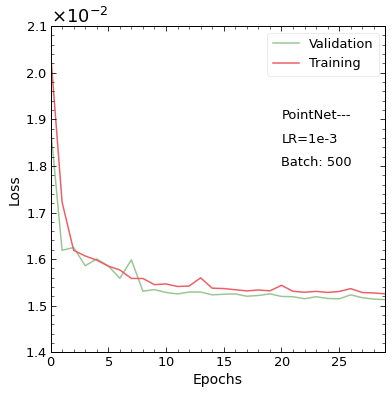

In [27]:
plot_dict = history_mmm_1

fig = plt.figure(figsize=(6,6))
plt.plot(plot_dict.history['val_loss'], label="Validation")
plt.plot(plot_dict.history['loss'], label="Training")
# plt.yscale('log')
# plt.ylim(2.3,3.5)
plt.yticks(fontsize=13)
plt.xlim(0,len(plot_dict.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1, frameon=True, fancybox=True)
plt.text(20, 1.9e-2, 'PointNet---', fontsize=13)
plt.text(20, 1.85e-2, 'LR=1e-3', fontsize=13)
plt.text(20, 1.8e-2, 'Batch: 500', fontsize=13)
# plt.savefig('Plots/December21/LossCurves_pnetMMM_LR1e-3_batch500_2021-12-02.png', format='png')
plt.show()

### Predictions

In [21]:
t0 = cput()
predictions = pnet_MinMinMin.predict(X_test)
t1 = cput()
print(predictions.shape)
print('Time to make predictions: '+str(t1-t0)+' (s)')

(4543, 848, 1)
Time to make predictions: 5.177791672758758 (s)


In [25]:
for i in range(Y_test.shape[1]):
    print(Y_test[1,i,:])

[0.75080976]
[0.45436323]
[0.51045565]
[0.64442645]
[0.29530155]
[0.32199741]
[0.43615102]
[0.50027886]
[0.36627199]
[0.85092634]
[0.45971812]
[0.25971284]
[0.53572042]
[0.52923994]
[0.64972592]
[0.18933924]
[0.36437035]
[1.]
[0.18079585]
[0.35501942]
[0.25311242]
[0.36967376]
[0.55070737]
[0.30455508]
[0.49992255]
[0.55298256]
[0.62844414]
[0.35766716]
[0.57119706]
[0.77696137]
[0.]
[0.81396565]
[0.68559588]
[0.77741184]
[0.79009126]
[0.34306789]
[0.78250162]
[0.29096449]
[0.84971588]
[0.74179904]
[0.41271028]
[0.33920113]
[0.97813217]
[0.93138819]
[0.]
[0.]
[0.34975596]
[0.21728081]
[0.92954265]
[0.]
[0.]
[1.]
[0.28876422]
[0.4233878]
[0.]
[0.3343146]
[0.94551845]
[1.]
[0.28811213]
[0.75799846]
[0.]
[0.]
[0.99336632]
[0.71683872]
[0.73518041]
[0.61241202]
[0.38126439]
[0.59952502]
[0.65308999]
[0.6516626]
[0.97972728]
[0.23225241]
[0.80936858]
[0.69689144]
[0.23856859]
[0.87750948]
[0.32516653]
[0.20566678]
[0.91357613]
[0.99984725]
[0.24697721]
[0.89633057]
[0.86106762]
[0.]
[0.]
[0

<Figure size 799.992x599.976 with 0 Axes>

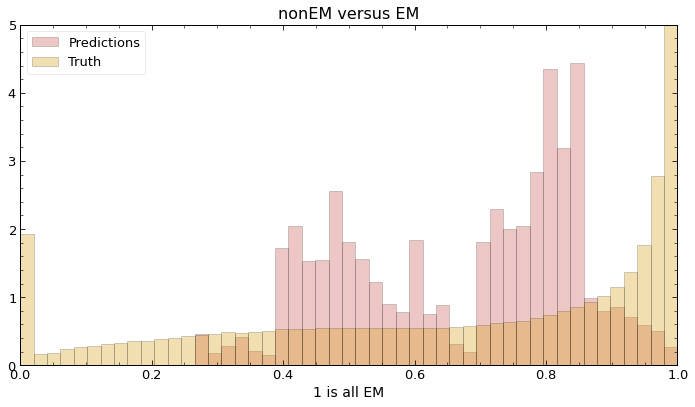

In [42]:
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])

plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,6))

EMbins = np.linspace(0,1,50, endpoint=True)
plt.hist(predictions[nz_test_mask], color='indianred', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Predictions')
plt.hist(Y_test[nz_test_mask], color='goldenrod', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Truth')
plt.title('nonEM versus EM', fontsize=16)
plt.xlabel('1 is all EM', fontsize=14)
plt.xlim(0,1)
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', frameon=True, fancybox=True, prop={'size': 13})
# plt.tight_layout()
# plt.savefig('Plots/December21/pnet_mmm_predsVsTruth_1.png', format='png')
plt.show()

## PointNet--
 - [ ] Lets try to add the transformation blocks as before!
 
### Convolution and Multi-Layer-Perceptron "blocks"

In [27]:
def conv_block(x, filters: int, name: str):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

def mlp_block(x: tf.Tensor, size: int, name: str):
    x = layers.Dense(size, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

def tdist_block(x, mask, size: int, number: str):
    dense = layers.Dense(size)
    x = layers.TimeDistributed(dense, name='t_dist_'+str(number))(x, mask=mask)
    x = layers.Activation('relu', name='activation_'+number)(x)
    return x

def bool_mask_fn(tensors):
    ''' The point of this is to use a Lambda Layer in order to return 
    a tensor which is all zeros for features where the mask is zero. '''
    x, tens_in = tensors
    full_mask = tf.logical_not(tf.math.equal(tens_in, 0))
    red_mask = tf.experimental.numpy.any(full_mask, axis=2)
    # mask = layers.Masking(mask_value=0., input_shape=tens_in.shape)(
    #     tens_in)._keras_mask
    return tf.boolean_mask(x, red_mask)

def cast_to_zero(tensors):
    ''' casts all values that should be zero to zero in the modified tensor '''
    mod_tens, input_tens = tensors
    full_mask = tf.logical_not(tf.math.equal(input_tens, 0))
    print(full_mask)
    reduced_mask = tf.experimental.numpy.any(full_mask, axis=-1)
    print(reduced_mask)
    print(reduced_mask.shape[1])
    reduced_mask = tf.expand_dims(reduced_mask, axis=-1)
    print(reduced_mask)
    print('repeats: '+str(mod_tens.shape[2]))
    full_mod_mask = tf.stack(reduced_mask, axis=2)
    print(full_mod_mask)
    float_mask = tf.cast(full_mod_mask, dtype=tf.float64)
    print(float_mask)
    return float_mask

def cast_to_zero2(tensors):
    ''' casts all values that should be zero to zero in the modified tensor '''
    mod_tens, input_tens = tensors
    full_mask = tf.logical_not(tf.math.equal(input_tens, 0))
    reduced_mask = tf.experimental.numpy.any(full_mask, axis=-1)
    reduced_mask = tf.expand_dims(reduced_mask, axis=-1)
    float_mask = tf.cast(reduced_mask, dtype=tf.float64)
    return float_mask
    
def mat_mult(tensors):
    x, y = tensors
    return tf.matmul(x, y)

def batch_dot(tensors):
    x, y = tensors
    return K.batch_dot(x, y)

class MaskedReduction(keras.layers.Layer):
    def __init__(self, name=None):
        super(MaskedReduction, self).__init__(name=name)
        
    def __call__(self, x, mask=None):
        if mask is None:
            return x
        else:
            # this ordering assumes (batch, timestep, features)
            return K.boolean_mask(x, mask, axis=-2)

In [28]:
def PointNet_MinMin(shape=(None, 848, 4), name=None):
    inputs = keras.Input(shape=shape, name="input")

    mask_tens = layers.Masking(mask_value=0.0, input_shape=shape)(inputs)
    keras_mask = mask_tens._keras_mask
    full_mask = K.not_equal(inputs, 0.)

    #======== MINI T-NET ====================================================#
    block_0 = tdist_block(inputs, mask=keras_mask, size=32, number='0')
    block_1 = tdist_block(block_0, mask=keras_mask, size=64, number='1')
    block_2 = tdist_block(block_1, mask=keras_mask, size=64, number='2')
    
    # mask outputs to zero
    # this may need to add compute_mask() to consume the keras mask.. TBD
    # masked_outputs = MaskedReduction(name='reduce_0')(block_2, mask=keras_mask)
    # float_mask = layers.Lambda(cast_to_zero2, name='temp_mask_0')([block_2, inputs])
    # masked_outputs = layers.Multiply(name='zero_cast_0')([block_2, float_mask])
    
    max_pool = layers.MaxPool1D(pool_size=shape[0])(block_2)
    mlp_tnet_0 = layers.Dense(64, activation='relu')(max_pool)
    mlp_tnet_1 = layers.Dense(32, activation='relu')(mlp_tnet_0)
    
    vector_dense = layers.Dense(
        shape[1]*shape[1],
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(shape[1]).flatten()),
        name='pre_matrix'
    )(mlp_tnet_1)
    
    mat_layer = layers.Reshape((shape[1], shape[1]), name='matrix')(vector_dense)
    
    matrix_multiply = layers.Lambda(batch_dot, name='matrix_multiply')([mask_tens, mat_layer])
    # tnet_out_0 = layers.TimeDistributed(matrix_multiply, name='t_dist_mat_mult')(
    #     [inputs, mat_layer], mask=keras_mask
    # )
    tnet_out_1 = layers.Activation('relu', name='tnet_act_out')(matrix_multiply)
    #========================================================================#
    
    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_3')(tnet_out_1, mask=keras_mask)
    activation_0 = layers.Activation('relu', name="activation_3")(t_dist_0)
    
    dense_1 = layers.Dense(200)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_4')(activation_0, mask=keras_mask)
    activation_1 = layers.Activation('relu', name="activation_4")(t_dist_1)

    dense_2 = layers.Dense(200)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_5')(activation_1, mask=keras_mask)
    activation_2 = layers.Activation('relu', name="activation_5")(t_dist_2)

    dense_3 = layers.Dense(100)
    t_dist_3 = layers.TimeDistributed(dense_3, name='t_dist_6')(activation_2, mask=keras_mask)
    activation_3 = layers.Activation('relu', name="activation_6")(t_dist_3)
    
    dense_4 = layers.Dense(50)
    t_dist_4 = layers.TimeDistributed(dense_4, name='t_dist_7')(activation_3, mask=keras_mask)
    activation_4 = layers.Activation('relu', name="activation_7")(t_dist_4)
    
    dense_5 = layers.Dense(1)
    t_dist_5 = layers.TimeDistributed(dense_5, name='t_dist_8')(activation_4, mask=keras_mask)
    activation_5 = layers.Activation('sigmoid', name="activation_8")(t_dist_5)

    return keras.Model(inputs=inputs, outputs=activation_5, name=name)

In [32]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

pnet_mm = PointNet_MinMin(shape=(848,4), name='PointNet--')

# point_optimizer2 = keras.optimizers.Adam(learning_rate=0.001)
pnet_mm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
pnet_mm.summary()

Model: "PointNet--"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 848, 4)]     0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 848, 32)      160         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 848, 32)      0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 848, 64)      2112        activation_0[0][0]               
_________________________________________________________________________________________

### Train PointNet--

In [33]:
print(X_train.shape)
print(Y_train.shape)

(21198, 848, 4)
(21198, 848, 1)


In [34]:
t0 = cput()

history_mm_1 = pnet_mm.fit(x=X_train, y=Y_train,
                           epochs=30,
                           batch_size=500,
                           validation_data=(X_val, Y_val),
                           verbose=1)

t1 = cput()

Train on 21198 samples, validate on 4542 samples
Epoch 1/30


2021-12-08 13:05:33.658348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9177 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2021-12-08 13:05:45.110012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


21000/21198 [============================>.] - ETA: 0s - loss: 0.0202

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


21198/21198 [==============================] - 16s 764us/sample - loss: 0.0202 - val_loss: 0.0183
Epoch 2/30
21198/21198 [==============================] - 4s 174us/sample - loss: 0.0166 - val_loss: 0.0153
Epoch 3/30
21198/21198 [==============================] - 4s 177us/sample - loss: 0.0149 - val_loss: 0.0145
Epoch 4/30
21198/21198 [==============================] - 4s 175us/sample - loss: 0.0145 - val_loss: 0.0143
Epoch 5/30
21198/21198 [==============================] - 4s 176us/sample - loss: 0.0143 - val_loss: 0.0142
Epoch 6/30
21198/21198 [==============================] - 4s 176us/sample - loss: 0.0143 - val_loss: 0.0141
Epoch 7/30
21198/21198 [==============================] - 4s 177us/sample - loss: 0.0142 - val_loss: 0.0141
Epoch 8/30
21198/21198 [==============================] - 4s 179us/sample - loss: 0.0141 - val_loss: 0.0140
Epoch 9/30
21198/21198 [==============================] - 4s 179us/sample - loss: 0.0138 - val_loss: 0.0135
Epoch 10/30
21198/21198 [=============

In [35]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 125.85783701576293 (s)
2.097630616929382 (min)
0.03496051028215637 (hour)


### Plot Loss Curves

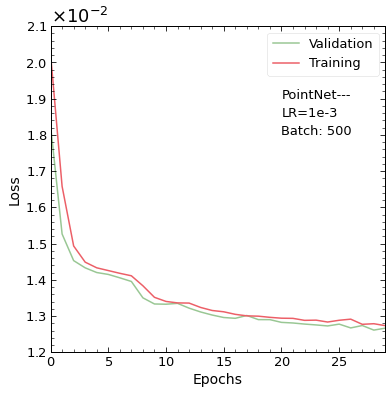

In [37]:
plot_dict = history_mm_1

fig = plt.figure(figsize=(6,6))
plt.plot(plot_dict.history['val_loss'], label="Validation")
plt.plot(plot_dict.history['loss'], label="Training")
# plt.yscale('log')
# plt.ylim(2.3,3.5)
plt.yticks(fontsize=13)
plt.xlim(0,len(plot_dict.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1, frameon=True, fancybox=True)
plt.text(20, 1.9e-2, 'PointNet---', fontsize=13)
plt.text(20, 1.85e-2, 'LR=1e-3', fontsize=13)
plt.text(20, 1.8e-2, 'Batch: 500', fontsize=13)
# plt.savefig('Plots/December21/LossCurves_pnetMM_LR1e-3_batch500_2021-12-08.png', format='png')
plt.show()

### Predictions

In [41]:
t0 = cput()
predictions_mm = pnet_mm.predict(X_test)
t1 = cput()
print(predictions_mm.shape)
print('Time to make predictions: '+str(t1-t0)+' (s)')

(4543, 848, 1)
Time to make predictions: 0.8586745737120509 (s)


### Predictions Hist

<Figure size 799.992x599.976 with 0 Axes>

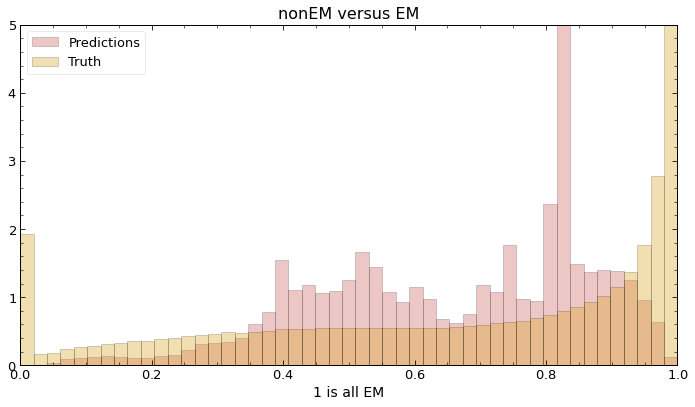

In [44]:
predictions_mm = predictions_mm.reshape(predictions_mm.shape[0], predictions_mm.shape[1])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])

plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,6))

EMbins = np.linspace(0,1,50, endpoint=True)
plt.hist(predictions_mm[nz_test_mask], color='indianred', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Predictions')
plt.hist(Y_test[nz_test_mask], color='goldenrod', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Truth')
plt.title('nonEM versus EM', fontsize=16)
plt.xlabel('1 is all EM', fontsize=14)
plt.xlim(0,1)
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', frameon=True, fancybox=True, prop={'size': 13})
# plt.tight_layout()
# plt.savefig('Plots/December21/pnet_mm_predsVsTruth_1.png', format='png')
plt.show()